# Calculate the nonstationary internal tide GP/spectral parameters

# Dask worker setup instructions

https://github.com/mrayson/pawsey-containers/tree/master/hpc-python/jupyter-sfoda

These settings do the job:

 1. `dask-scheduler --scheduler-file scheduler-$HOSTNAME.json --idle-timeout 0`
 2. `ssh localhost "cd /software/projects/pawsey0106/mrayson/projects && sbatch --time=04:00:00 --ntasks=64 -c 16 start_worker.slm scheduler-$HOSTNAME.json ./"`
 


In [2]:
hostname = !echo $(hostname)
hostname[0]

'nid002024'

In [3]:
import os
from distributed import Client
client=Client(scheduler_file='../../scheduler-' + hostname[0] + '.json')
client

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


<Client: 'tcp://10.253.128.99:8786' processes=64 threads=1024, memory=1.68 TiB>

In [4]:
client.restart()

<Client: 'tcp://10.253.128.99:8786' processes=0 threads=0, memory=0 B>

In [5]:
# Make sure the workers can see the paths
# https://distributed.dask.org/en/latest/plugins.html#distributed.diagnostics.plugin.UploadDirectory
# from distributed.diagnostics.plugin import UploadDirectory

# _=client.register_worker_plugin(UploadDirectory("/software/projects/pawsey0106/mrayson/projects/incoherentitide"), nanny=True) 

In [6]:
# client.restart() # This clears all data

In [7]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import numpy as onp
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map

# from jax import numpy as np
# import jax 
# import optax
# import nonstat_itides_jax as nsjax # Cannot import this to workers :(

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-v2dzluzt because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [8]:
# from jax.interpreters import xla
# xla._xla_callable.cache_clear()
# loss._clear_cache()

In [9]:
# jax.__version__

In [10]:
#####
# nonstat_itides_jax.py
#####
from functools import partial
from jax import numpy as np
import jax 
import optax

###########################
# Speccy jax version
###########################
# Speccy jax stuff


def is_even(x):
    return x % 2 == 0

def n_freq(n):
    return int(np.floor(n/2))

def taus(n, delta):
    return delta * np.arange(n)

def fftshift(x):
    return np.fft.fftshift(x)

def fftfreq(n, delta):
    return fftshift(np.fft.fftfreq(n, delta))

def periodogram(ts, delta = 1, h = None):
    
    n = ts.size

    if h is not None:
        norm = np.sum(h**2)
        scale = np.sqrt(n/norm)
        ts = scale * h * ts

    dft = np.fft.fft(ts)/np.sqrt(n/delta)
    
    I = np.real(dft * np.conj(dft))
    ff = np.fft.fftfreq(n, delta)

    return fftshift(ff), fftshift(I)

def whittle(ts, specfunc, params, delta = 1, h = None):
    
    ff, I = periodogram(ts, delta, h)
    S = specfunc(ff, params)

    ll = - (np.log(S) + I/S)
    idx = (ff != 0) * (ff != -0.5/delta)
    
    return np.sum(ll[idx])

def dwhittle(ts, acffunc, params, delta = 1, h = None):
    
    tt = delta * np.arange(ts.size)
    ff, I = periodogram(ts, delta, h)
    ff_boch, S_boch = bochner(acffunc(tt, params), delta = delta, bias = True)
    # HACK: quick fix cause bochner isn't two sided yet
    return - 2 * np.sum(np.log(S_boch[ff_boch > 0]) + I[ff > 0]/S_boch[ff_boch > 0])

def bochner(acf, delta = 1, bias = True, h = None):

    n = np.size(acf)

    if h is not None:
        
        norm = np.sum(h**2)
        h_conv = (np.convolve(h, h, mode = 'full')/norm)[(n-1):]
        acf = h_conv * acf

    elif bias:

        acf = (1 - np.arange(n)/n) * acf

    ff = fftfreq(n, delta)

    if is_even(n):
        acf = np.concatenate([np.array([acf[0]/2]), acf[1:(n-1)], np.array([acf[-1]/2])])
    else:
        acf = np.concatenate([np.array([acf[0]/2]), acf[1:n]])
    
    psd = 2 * delta * np.real(np.fft.fft(acf))

    return ff, fftshift(psd)

#################################
# Covariance models - Jax version
##################################

def logit(p, scale=1.):
    cff = 1/scale
    return np.log(p*cff/(1-p*cff))

def invlogit(x, scale=1.):
    return scale*np.exp(x)/(1+np.exp(x))

# Covariance kernels / ACFs
def calc_dist(x, xpr, eps=1e-14):
    dx2 = np.power(x-xpr, 2.)
    #dx2[dx2<eps] = eps
    #dx2 = dx2.at[dx2<eps].set(eps)
    dx2 = np.where(dx2 < eps, eps, dx2)
    return np.sqrt(dx2)

def cosine(x, xpr, l):
    """Cosine base function"""
    return np.cos(2*np.pi*np.abs(x-xpr)/l)


def gamma_exp(x, xpr, gam, l):
    """γ-exponential covariance function"""
    dx = calc_dist(x, xpr)
    return np.exp(-np.power(dx/l, gam))

def gamma_exp_1d(x, xpr, params):
    """
    1D Oscillatory kernel
    """
    eta, d, gam = params

    return eta**2 * gamma_exp(x, xpr, gam, d) 
    
def oscillate_1d_matern(x, xpr, params):
    """
    1D Oscillatory kernel
    """
    eta, d, l, nu = params

    return eta**2 * matern_general(x, xpr, nu, d) * cosine(x, xpr, l)

def oscillate_1d_gammaexp(x, xpr, params):
    """
    1D Oscillatory kernel
    """
    eta, d, l, gam = params

    return eta**2 * gamma_exp(x, xpr, gam, d) * cosine(x, xpr, l)

def itmodel_gamma(x, xpr, params, l=0.5):
    
    eta, d,  gam = params
    #gam = nsit.invlogit(logit_gam, scale=2.)

    return oscillate_1d_gammaexp(x, xpr, (eta, d, l, gam) )

def oscillate_D2D1_gammaexp(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2]):

    eta1, d1, eta2, d2, gam1, gam2 = params
    

    C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, lt[0], gam1))
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[1], gam2))

    return C

def oscillate_D2D1_gammaexp_fixed(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2],
                                 gam1=1.5, gam2=1.5):

    eta1, d1, eta2, d2, constant = params
    

    C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, lt[0], gam1))
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[1], gam2))
    
    #C[0] = C[0] + constant
    C = C.at[0].add(constant)

    return C

def oscillate_fD2D1_gammaexp(x, xpr, params, 
                     f_cor=2,
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2],
                                 gam=1.5):

    eta1, d1, eta2, d2, eta3, d3 = params
    
    C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, f_cor, gam))
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[0], gam))
    C += oscillate_1d_gammaexp(x, xpr, (eta3, d3, lt[1], gam))

    return C


def itide_fD2D1_meso_gammaexp(x, xpr, params, **kwargs):
    eta_m, l_m, gam_m, eta1, d1,  eta2, d2, eta3, d3 = params

    C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
    C += oscillate_fD2D1_gammaexp(x, xpr, (eta1, d1, eta2, d2, eta3, d3), **kwargs)
    return C

def itide_D2_meso_gammaexp(x, xpr, params, 
                     lt = 0.5):

    eta_m, l_m, gam_m, eta2, d2, gam1 = params
    
    C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt, gam1))

    return C

def oscillate_D2D1_gammaexp(x, xpr, params, 
                     f_cor=2,
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2],
                                 gam=1.5):

    eta2, d2, eta3, d3 = params
    
    C = oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[0], gam))
    C += oscillate_1d_gammaexp(x, xpr, (eta3, d3, lt[1], gam))

    return C


def itide_meso_nof_gammaexp(x, xpr, params, **kwargs):
    eta_m, l_m, gam_m, eta2, d2, eta3, d3 = params

    C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
    C += oscillate_D2D1_gammaexp(x, xpr, (eta2, d2, eta3, d3), **kwargs)
    return C

def itide_D2_meso_gammaexp_fixed(x, xpr, params, 
                     lt = 0.5, gam1 = 1.0):

    eta_m, l_m, gam_m, eta2, d2 = params
    
    C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt, gam1))

    return C

def itide_M2S2_meso_gammaexp(x, xpr, params, 
                     lt = [0.5175, 0.5] ):

    eta_m, l_m, gam_m, etaM2, etaS2, tauM2, tauS2, gammaM2, gammaS2 = params
    
    C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
    C += oscillate_1d_gammaexp(x, xpr, (etaM2, tauM2, lt[0], gammaM2))
    C += oscillate_1d_gammaexp(x, xpr, (etaS2, tauS2, lt[1], gammaS2))
    return C

def itide_M2S2_meso_gammaexp_fixed(x, xpr, params, 
                     lt = [0.5175, 0.5], gamma=1 ):

    eta_m, l_m, gam_m, etaM2, etaS2, tauM2, tauS2 = params
    
    C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
    C += oscillate_1d_gammaexp(x, xpr, (etaM2, tauM2, lt[0], gamma))
    C += oscillate_1d_gammaexp(x, xpr, (etaS2, tauS2, lt[1], gamma))
    return C

#################################################
# Jax parameter estimation/optimisation routines
#################################################
# Transformation of optimiser parameters
class LogTransformer:
    def __init__(self,params):
        self.params = params

    def __call__(self):
        return np.log(self.params)
    
    def out(self, tparams):
        return np.exp(tparams)

class LinearTransformer:
    def __init__(self,params, scale=1., offset=0.):
        self.scale = scale
        self.offset = offset
        self.params = params

    def __call__(self):
        return (self.params-offset)/scale
    
    def out(self, tparams):
        return self.params*scale + offset

class CustomTransformer:
    def __init__(self,params):
        self.params = params

    def __call__(self):
        params_t = np.log(self.params)
        params_t = params_t.at[2].set(invlogit(self.params[2],scale=2))
        params_t = params_t.at[5].set(invlogit(self.params[5],scale=2))
        return params_t
        
    def out(self, tparams):
        params = np.exp(tparams)
        #params[2] = nsjax.logit(tparams[2],scale=2)
        #params[5] = nsjax.logit(tparams[5],scale=2)
        params = params.at[2].set(logit(tparams[2],scale=2))
        params = params.at[5].set(logit(tparams[5],scale=2))
        return params
        
###
# Loss functions
def dwhittle_fast(x, y, ff, I, acffunc, params, fidx, delta = 1, h = None, fmin=0, fmax=np.inf, acf_kwargs={}):
    ff_boch, S_boch = bochner(acffunc(x, x[0], params, **acf_kwargs), delta = delta, bias = True)
    # Subset frequencies
    #idx = (ff > fmin) & (ff<fmax)
    whit = np.log(S_boch) + I/S_boch
    return -2* np.where(fidx, whit, 0).sum()

@jax.value_and_grad
@partial(jax.jit, static_argnums=(6,7,8))
def loss(logparams,  X, y, f, I, fidx, covfunc,  dt,  Transformer, acf_kwargs):
    params = Transformer.out(logparams)
    return -dwhittle_fast(X, y, f, I, covfunc, params, fidx, delta=dt, acf_kwargs=acf_kwargs) 

#####
# Main optimisation routine
#####
def estimate_jax(y, X, covfunc, covparams_ic, fmin, fmax,
                fidx=None,
                cov_kwargs={},
                window=None,
                verbose=True,
                maxiter=500,
                ftol=1e-2,
                opt= optax.sgd(learning_rate=3e-4),
                transformer=LogTransformer):

    dt = X[1]-X[0]
    f, I = periodogram(y, delta=dt, h=window)
    if fidx is None:
        fidx = (f > fmin) & (f<fmax)
    
    # def dwhittle_jax(params, acffunc):
    #     ff_boch, S_boch = bochner(acffunc(x, x[0], params))
    #     whit = np.log(S_boch) + I/S_boch
    #     return -2* np.where(idx, whit, 0).sum()
    
    # @jax.value_and_grad
    # @partial(jax.jit, static_argnums=(1))
    # def loss2(logparams, covfunc):
    #     params = np.exp(logparams)
    #     return -dwhittle_jax(params, covfunc) 

    T = transformer(np.array(covparams_ic))
    logparams = T()
    
    opt_state = opt.init(logparams)
    loss_val = np.inf
    for i in range(maxiter):
        loss_val_new, grads = loss(logparams, np.array(X), np.array(y), f, I, fidx, 
                                   covfunc,  dt, T, cov_kwargs)
        #loss_val_new, grads = loss2(logparams, covfunc)
        updates, opt_state = opt.update(grads, opt_state)
        logparams = optax.apply_updates(logparams, updates)
        
        if i % 25 == 0:
            if verbose:
                print(f'step {i}, loss: {loss_val_new}')
                print(np.exp(logparams))
        if np.abs(loss_val_new-loss_val) < ftol:
            if verbose:
                print(f'step {i}, loss: {loss_val}')
            break
    
        loss_val = 1*loss_val_new
        
    return T.out(logparams), loss_val
    #return np.concatenate([T.out(logparams), np.array([loss_val])])


In [11]:
ls ~/

adept/                    jupyter-18133600.out         s3.acacia.login
core                      jupyter_sfoda_20240314.sif*  scheduler-nid002024.json
dask-worker-18130112.out  kdv_uncertainty/             scheduler-nid002573.json
dask-worker-18131563.out  nliw-gp/                     start_jupyter.slm
dask-worker-18133608.out  nwa_swot_tides/              start_worker.slm
dask-worker-space/        ocen4008/                    suntans-nws/
incoherentitide/          roms_4dvar_browsebasin/      swot-nws/
jupyter-18130065.out      roms-suntans-coupling/       westcoast-mhw/


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [12]:
s3login = '/scratch/pawsey0106/mrayson/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)


In [13]:
def save_load_chunk(ds, i1, i2, varname):
    
    tmpfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/tmp.zarr'
    
    y = ds[varname].\
        sel(time=slice('2013-07-15','2014-07-01')).isel(Nc=slice(i1, i2))#.chunk({'Nc':1})##.chunk({'Nc':1})
    X = (y.time-y.time[0]).values.astype(float)/1e9/86400

    dsout = xr.Dataset({'y':y}) #
    dsout
    dsout['y'].encoding['chunks']={'chunks':(8425,100) }
    dsout['y'].encoding['preferred_chunks']={'time': 8425, 'Nc': 100},
    dsout.to_zarr(tmpfile, compute=True, mode='w')

    # ds = xr.load_dataset(tmpfile, engine='zarr', chunks={}).chunk({'Nc':1}) # This loads the data?
    dsnew = xr.load_dataset(tmpfile, engine='zarr').chunk({'Nc':1})

    #y_ = da.from_zarr(tmpfile, component='y')
    
    return dsnew['y'], X, ds['yv'].isel(Nc=slice(i1, i2)).chunk({'Nc':100})



In [14]:
###
# Inputs
# eta1 = 0.01
# eta2 = 0.005
# eta3 = 0.01
# dt1 = 5.
# dt2 = 2.0
# dt3 = 2.

# eta_m = 0.1
# l_m = 0.1
# gam_m = 0.5

# fmin = 1e-3 
# fmax = 2.5 #

# # covfunc=itide_fD2D1_meso_gammaexp
# # covparams = (eta_m, l_m, gam_m, eta1, dt1, eta2, dt2, eta3, dt3,)
# # paramnames = ['η_m','τ_m','γ_m','η_f','τ_f','η_D2','τ_D2', 'η_D1','τ_D1', ]

# covfunc=itide_meso_nof_gammaexp
# covparams = (eta_m, l_m, gam_m, eta2, dt2, eta3, dt3,)
# paramnames = ['η_m','τ_m','γ_m','η_D2','τ_D2', 'η_D1','τ_D1', ]

eta_m = 0.1
l_m = 20.
gam_m = 1.5
etaM2 = 0.01
etaS2 = 0.01
tauM2 = 5.
tauS2 = 5.
gammaM2 = 1.5
gammaS2 = 1.5

# name = 'M2S2'
# covfunc = itide_M2S2_meso_gammaexp
# covparams = (eta_m, l_m, gam_m, etaM2, etaS2, tauM2, tauS2, gammaM2, gammaS2)
# paramnames = ['η_m','τ_m','γ_m','η_M2','η_S2','τ_M2','τ_S2', 'γ_M2','γ_S2', ]
# cov_kwargs={}

name = 'M2S2_gamma_1_5'
cov_kwargs= dict(gamma=1.5)
covfunc = itide_M2S2_meso_gammaexp_fixed
covparams = (eta_m, l_m, gam_m, etaM2, etaS2, tauM2, tauS2)
paramnames = ['η_m','τ_m','γ_m','η_M2','η_S2','τ_M2','τ_S2' ]

fmins = [1e-4, 1.5]
fmaxs = [0.2, 2.5]
fmin = 1e-4 
fmax = 2.5 

#invarname = 'eta'
invarname = 'vc'
#invarname = 'uc'

outfile = f'/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_{name}_{invarname}.zarr'
outfile_nc = f'/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_{name}_{invarname}.nc'

zarrin = 'NWS_2km_GLORYS_2013_2014_{}_seasonaltides.zarr'.format(invarname)
varname = '{}_non_phase_locked'.format(invarname)
dropvars=['{}_non_phase_locked'.format(invarname),'{}_phase_locked'.format(invarname)]

#####


# Change notes:
 - 

In [15]:
f = S3Map("uwaoceanprocesses-suntans/"+zarrin, s3=s3)

ds = xr.open_dataset(f, engine='zarr', chunks={})

# These need filling in??
#ds.suntans.xv=ds.xv.values
#ds.suntans.yv=ds.yv.values

ds

<xarray.Dataset> Size: 32GB
Dimensions:              (Nc: 225368, numsides: 8, Nk: 80, time: 8761,
                          Np: 454016)
Coordinates:
  * time                 (time) datetime64[ns] 70kB 2013-07-01T00:01:00 ... 2...
    z_r                  (Nk) float64 640B dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells                (Nc, numsides) int32 7MB dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv                   (Nc) float64 2MB dask.array<chunksize=(2000,), meta=np.ndarray>
    dz                   (Nk) float64 640B dask.array<chunksize=(80,), meta=np.ndarray>
    nfaces               (Nc) int32 901kB dask.array<chunksize=(2000,), meta=np.ndarray>
    vc_non_phase_locked  (time, Nc) float64 16GB dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    vc_phase_locked      (time, Nc) float64 16GB dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    xp                   (Np) float64 4MB dask.array<chunksize=(454016,), meta=np.ndarray>
    xv                   (Nc) float64 2MB dask.array<chunksize=(2000,), meta=np.ndarray>
    yp                   (Np) float64 4MB dask.array<chunksize=(454016,), meta=np.ndarray>
    yv                   (Nc) float64 2MB dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [16]:
# def compute_f_cpd_inv(lat):
#     f_cor = 4*np.pi/86400*np.sin(np.abs(lat)*np.pi/180)
#     return 2*np.pi/f_cor/86400

# def estimate_spectral_params_jax(y, lat, X=None, covfunc=None, covparams_ic=None, fmin=None, fmax=None):
    
#     f_cor_cpd = compute_f_cpd_inv(lat)
    
#     params, loss_val = estimate_jax(y, X, covfunc, covparams, fmin, fmax,
#                          cov_kwargs={'f_cor':f_cor_cpd},
#                           maxiter=500,
#                          opt= optax.adabelief(learning_rate=1e-1),
#                          verbose=False)
#     jax.clear_caches()
#     return params, np.array([loss_val])

#inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=None, fmax=None, fidx=fidx)



In [17]:
# # Load a point to work out the frequencies we need to subset
# idx = 0
# y = ds[varname].isel(Nc=idx).sel(time=slice('2013-07-15','2014-07-01'))

# tdays = (ds.time-ds.time[0]).values.astype(float)/1e9/86400
# X = tdays#[:,None]
# dt = X[1]-X[0]

# f, I = periodogram(y.values, dt)

# fidx = ((f > fmins[0]) & (f<fmaxs[0])) | ((f > fmins[1]) & (f<fmaxs[1]))
# fidx.shape

In [18]:
def estimate_spectral_params_jax2(y, lat, X=None, covfunc=None, covparams_ic=None, fmin=None, fmax=None, fidx=None):
    #print(lat)
    
    #f_cor_cpd = compute_f_cpd_inv(lat)
    
    params, loss_val = estimate_jax(y, X, covfunc, covparams, fmin, fmax,
                         fidx = fidx,
                         cov_kwargs=cov_kwargs,
                         maxiter=500,
                         opt= optax.adabelief(learning_rate=1e-1),
                         verbose=False)
    
    #jax.clear_caches()
    return params#, np.array([loss_val])

# Loop through in chunks
step = 10000
mode='w'
append_dim = None


for ii in range(0, ds.dims['Nc'], step):
    i1 = ii
    i2 = ii+step
    if i2 > ds.dims['Nc']:
        i2 = ds.dims['Nc']
    print(i1,i2, ds.dims['Nc'])
    
    print('\tSubsetting the data...')
    y, X, lat = save_load_chunk(ds, i1, i2, varname)
    
    dt = X[1]-X[0]
    f, I = periodogram(np.zeros_like(X), dt)
    fidx = ((f > fmins[0]) & (f<fmaxs[0])) | ((f > fmins[1]) & (f<fmaxs[1]))
    
    window=None
    #window=hann(X.shape[0]) 
    #inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax)
    inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=None, fmax=None, fidx=fidx)
    
    print('\tBuilding the dask graph...')

    #params, loss_val
    params = xr.apply_ufunc(estimate_spectral_params_jax2,
                      y,
                      lat,
                      dask='parallelized',
                      kwargs=inputs,
                      #output_dtypes=[y.dtype, y.dtype],
                      output_dtypes=[y.dtype,],
                      input_core_dims=(['time',],[]),
                      #output_core_dims=(['params'],[]),
                      output_core_dims=(['params'],),
                      #output_sizes=,
                      dask_gufunc_kwargs={'output_sizes':{'params':len(covparams)}},
                      vectorize=True,
                     )
    
    
    print('\tComputing parameters...')
    params = params.compute()  
    jax.clear_caches()
    
    dsout = ds.drop_vars(dropvars).isel(Nc=slice(i1,i2))
    
    dsout['data'] = params.chunk({'Nc':2000})
    dsout['data'].attrs = {'long_name':'Estimated covariance model parameters','location':'face',
                                     'parameter names':paramnames,
                          'covariance function':covfunc.__name__,
                           'input file':zarrin} 
    
    # Include the coriolis term used for the covariance calculation
    #dsout['f_cpd_inv'] = xr.DataArray(compute_f_cpd_inv(lat.values), dims=('Nc',),
    #                             attrs={'long_name':'Inverse Coriolis frequency','units':'cpd'})
    
    # dsout = xr.Dataset({'data':params})
    print('\tSaving output...')
    dsout.to_zarr(outfile, mode=mode, append_dim=append_dim, compute=True)
    append_dim='Nc'
    mode='a'
    print('\t\tDone.')

    #break

/tmp/ipykernel_2867671/3335441459.py:22: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ii in range(0, ds.dims['Nc'], step):
/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


0 10000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
10000 20000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
20000 30000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
30000 40000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
40000 50000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
50000 60000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
60000 70000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
70000 80000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
80000 90000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
90000 100000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
100000 110000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
110000 120000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
120000 130000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
130000 140000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
140000 150000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
150000 160000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...
	Saving output...
		Done.
160000 170000 225368
	Subsetting the data...


/tmp/ipykernel_2867671/3335441459.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if i2 > ds.dims['Nc']:
/tmp/ipykernel_2867671/3335441459.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(i1,i2, ds.dims['Nc'])


	Building the dask graph...
	Computing parameters...


KilledWorker: ("('xarray-y-ab992c15ac19ce0e871bc794cad0a955', 0, 3802)", <WorkerState 'tcp://10.253.135.45:38397', status: closed, memory: 0, processing: 2264>)

In [ ]:
outfile, outfile_nc

In [ ]:
dsnew = xr.open_dataset(outfile, engine='zarr')

dsnew.to_netcdf(outfile_nc)
dsnew


In [ ]:
%matplotlib notebook

In [ ]:
plt.figure(figsize=(8,5))
# dsnew.suntans.plotcelldata(np.exp(dsnew['data'].isel(params=0))*1e4, cmap='Reds', vmin=0,vmax=200)
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=0))*100, cmap='Reds', vmin=0,vmax=30)

plt.title('Incoherent mesoscale amplitude [cm]')

In [ ]:
plt.figure(figsize=(8,5))
# dsnew.suntans.plotcelldata(np.exp(dsnew['data'].isel(params=1)), cmap='viridis', vmin=0, vmax=40)
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=1)), cmap='viridis', vmin=0, vmax=20)

plt.title('Incoherent mesoscale decay time scale [days]')

In [ ]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=3))*100, cmap='Reds', vmin=0.,vmax=5)
# dsnew.suntans.plotcelldata(np.abs(dsnew['data'].isel(params=2))*1e4, cmap='Reds', vmax=200)

plt.title('Incoherent M2 variance [cm]')

In [ ]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=4))*100, cmap='Reds', vmin=0.,vmax=5)
# dsnew.suntans.plotcelldata(np.abs(dsnew['data'].isel(params=2))*1e4, cmap='Reds', vmax=200)

plt.title('Incoherent S2 variance [cm]')

In [ ]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=5)), cmap='viridis', vmin=0, vmax=15)
plt.title('Incoherent M2 decay time scale [days]')

In [ ]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=6)), cmap='viridis', vmin=0, vmax=15)
plt.title('Incoherent S2 decay time scale [days]')

<IPython.core.display.Javascript object>


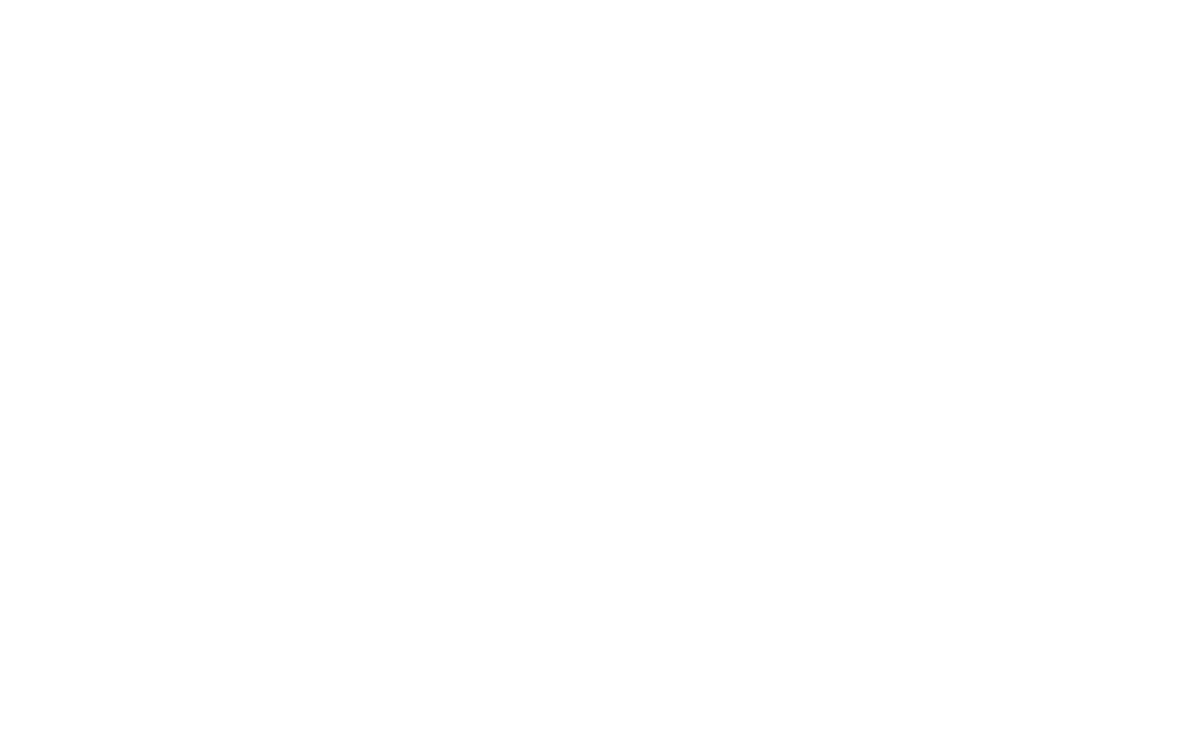

IndexError: index 7 is out of bounds for axis 0 with size 7

In [31]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=7)), cmap='bone_r', vmin=1, vmax=2)
plt.title('gamma M2')

In [ ]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=8)), cmap='bone_r', vmin=1, vmax=2)
plt.title('gamma S2')